In [1]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt

In [2]:
current_directory = os.path.dirname(os.getcwd())
image_path = os.path.join(current_directory, 'pictures', 'coins2.jpg')

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = image[:, :, [2, 1, 0]]

312 252 (312, 252, 3)
312 252 (312, 312, 3)


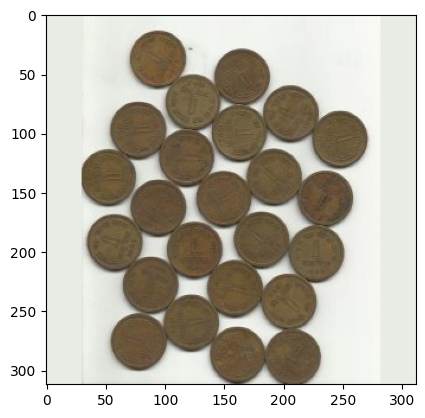

In [3]:
max_size, min_size = max(image.shape[:-1]), min(image.shape[:-1])
width, height = image.shape[:-1]
print(width, height, image.shape)

img = np.zeros((max_size, max_size, 3))
img[:,:] = image[0,0]

d2 = (max_size - min_size)//2

if width > height:
    img[:, d2:-d2] = image
else:
    img[d2:-d2, :] = image

print(width, height, img.shape)
img = img.astype(int)
plt.imshow(img)

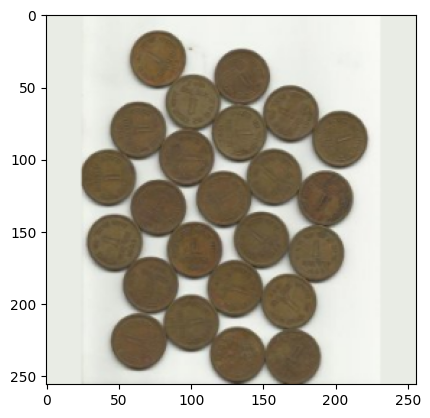

In [4]:
img_res = cv2.resize(img/255,(256,256), interpolation=cv2.INTER_AREA)
img_res = (img_res * 255).astype(np.uint8)
plt.imshow(img_res)

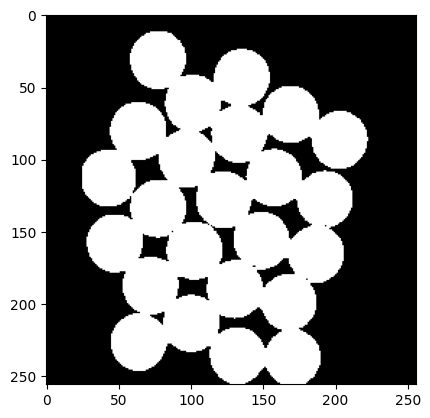

In [5]:
# upper = (250,)*3
# lower = (20,)*3

upper = (150,)*3
lower = (30,)*3

thresh = cv2.inRange(img_res, lower, upper)

plt.imshow(thresh, cmap='gray')

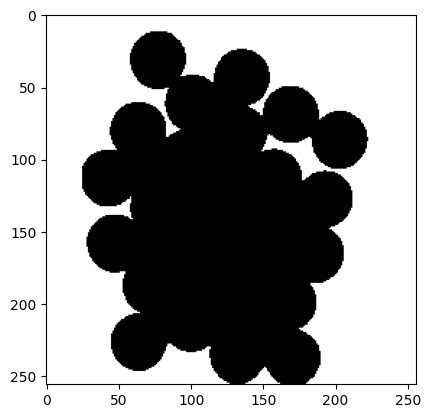

In [6]:
contours = cv2.findContours(thresh , cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

# draw white filled contours on black background
mask = np.zeros_like(img_res)
for cntr in contours:
    cv2.drawContours(mask, [cntr], 0, (255,255,255), -1)

mask = 255 - mask

plt.imshow(mask)

In [7]:
def rotate(image, angle, center = None, scale = 1.0):
    (h, w) = image.shape[:2]

    if center is None:
        center = (w / 2, h / 2)

    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h),
                           borderMode=cv2.BORDER_CONSTANT,
                           borderValue=image[0,0])

    return rotated

def gen_random(images: list, size = 128):
    out_images = []

    idx = np.random.randint(10000)
    angle = np.random.random() * 360
    blur_strength = np.random.randint(1,5)
    px_crops = None

    for img in images:
        n_img = img.copy().astype(np.float64)
    
        if idx % 2 == 0:
            n_img = rotate(n_img, angle)

        # crop
        img_size = min(n_img.shape[:-1])
        px_crops = px_crops if px_crops is not None else np.random.randint(img_size - size, size=2)
        n_img = n_img[px_crops[0]:px_crops[0] + size, px_crops[1]:px_crops[1] + size]

        if idx % 5 == 0:
            n_img = cv2.blur(n_img, (blur_strength,blur_strength))
        
        
        if idx % 5 == 3:
            kernel = np.array([[-1,-1,-1], 
                            [-1, 9,-1],
                            [-1,-1,-1]])
            n_img = cv2.filter2D(n_img, -1, kernel)

        n_img = np.clip(n_img, 0, 255).astype(int)

        out_images.append(n_img)
    
    return out_images


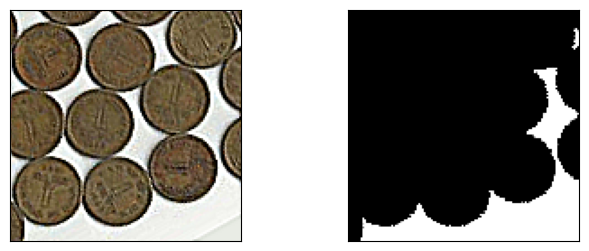

In [8]:
i, m = img_res, mask
while True:
    i, m = gen_random([img_res, mask])
    break


fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plt.imshow(i)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plt.imshow(m)

In [9]:
# save
import os
import pandas as pd

def save_gen(image, mask, count=100):
    mask[mask==-1] = 255
    markers_scale = np.clip(mask*(255./mask.max()), 0, 255).astype('uint8')

    imgs = []
    msks = []

    save_path = os.path.join(current_directory, 'pictures', 'lab6_data_images')

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    for i in range(count):
        img, msk, mark_s = gen_random([image, mask, markers_scale])
        img = img.astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(f"{save_path}/{i}i.jpg", img)
        cv2.imwrite(f"{save_path}/{i}m.jpg", mark_s)

        msk[msk==255] = -1

        im_f = img.flatten()
        msk_f = msk.flatten()
        # print(im_f, msk_f)
        # print(im_f.shape, msk_f.shape)

        imgs.append(im_f)
        msks.append(msk_f)

    imgs = np.array(imgs)
    msks = np.array(msks)
    # print(imgs.shape, msks.shape)
    
    df_imgs = pd.DataFrame(imgs)
    df_msks = pd.DataFrame(msks)

    df_imgs.to_csv(f"{save_path}/imgs.csv")
    df_msks.to_csv(f"{save_path}/msks.csv")


In [11]:
# save_gen(img_res, mask)

2

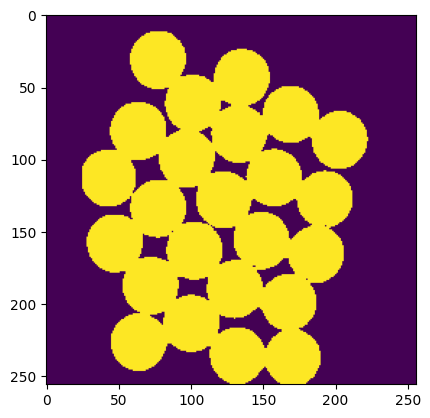

In [10]:
# gray = cv2.cvtColor(img_res,cv2.COLOR_BGR2GRAY)
# ret, thresh = cv2.threshold(gray,0,205,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.imshow(thresh)

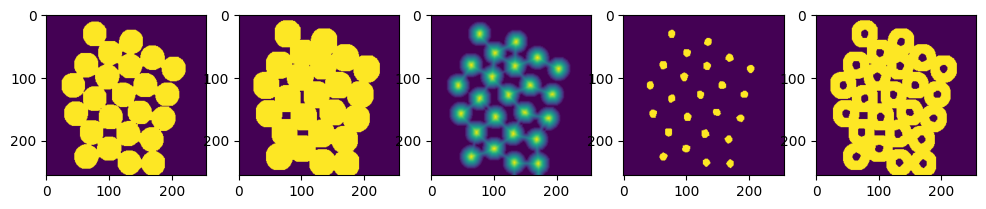

In [11]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 5)
 
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=2)
 
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
 
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

fig, ax = plt.subplots(1, 5, figsize=(12,12))
ax[0].imshow(opening)
ax[1].imshow(sure_bg)
ax[2].imshow(dist_transform)
ax[3].imshow(sure_fg)
ax[4].imshow(unknown)

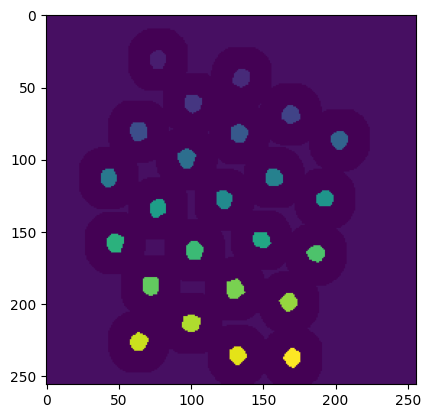

In [12]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
 
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
 
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

plt.imshow(markers)

-1


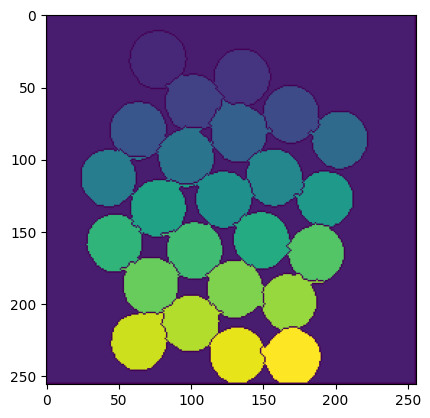

In [13]:
markers = cv2.watershed(img_res,markers)

img2 = img_res.copy()

img2[markers == -1] = [255,0,0]

plt.imshow(markers)
print(markers.min())

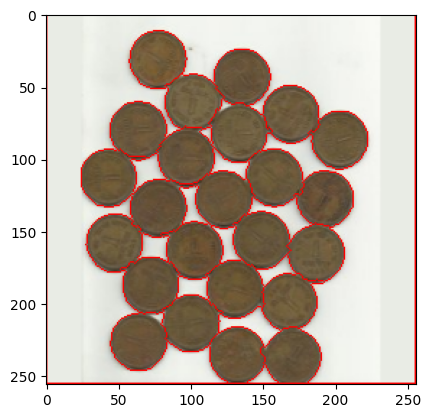

In [14]:
plt.imshow(img2)

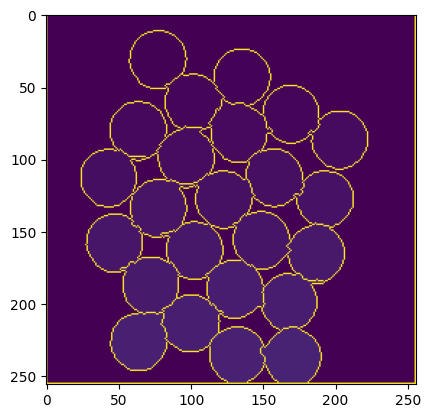

In [15]:
save_gen(img_res, markers)
plt.imshow(markers)